In [1]:
# For this notebook to work, you need to set up your environment as specified in the readme of https://github.com/gordonwatts/pyhep-2021-SX-OpenDataDemo

import asyncio, os
import numpy as np
from coffea.processor.servicex import Analysis, DataSource, LocalExecutor, DaskExecutor
from func_adl import ObjectStream
from func_adl_servicex import ServiceXSourceUpROOT
from servicex.servicex import ServiceXDataset
import hist
import re
import matplotlib.pyplot as plt
%matplotlib inline

import infofile # Same infofile used in https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

In [2]:
prefix = 'root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22/4lep/'

fileset = {'Data': [
                    prefix + 'Data/data_A.4lep.root',
                    prefix + 'Data/data_B.4lep.root',
                    prefix + 'Data/data_C.4lep.root',
                    prefix + 'Data/data_D.4lep.root'
                    ],
           'Background $Z,tt^{bar}$': [
                                       prefix + 'MC/mc_361106.Zee.4lep.root',
                                       prefix + 'MC/mc_361107.Zmumu.4lep.root',
                                       prefix + 'MC/mc_410000.ttbar_lep.4lep.root'
                                       ],
           'Background $ZZ^{star}$': [prefix + 'MC/mc_363490.llll.4lep.root'],
           'Signal ($m_H$ = 125 GeV)': [
                                        prefix + 'MC/mc_345060.ggH125_ZZ4lep.4lep.root',
                                        prefix + 'MC/mc_344235.VBFH125_ZZ4lep.4lep.root',
                                        prefix + 'MC/mc_341964.WH125_ZZ4lep.4lep.root',
                                        prefix + 'MC/mc_341947.ZH125_ZZ4lep.4lep.root'
                                       ]}

xsec_map = infofile.infos  # dictionary with event weighting information

In [3]:
# Method from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

def get_xsec_weight(sample):
    info = xsec_map[sample]
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [4]:
# Adapted from method from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[:,0]*np.cos(lep_phi[:,0]) # x-component of lep[0] momentum
    py_0 = lep_pt[:,0]*np.sin(lep_phi[:,0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[:,0]*np.sinh(lep_eta[:,0]) # z-component of lep[0] momentum
    px_1 = lep_pt[:,1]*np.cos(lep_phi[:,1]) # x-component of lep[1] momentum
    py_1 = lep_pt[:,1]*np.sin(lep_phi[:,1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[:,1]*np.sinh(lep_eta[:,1]) # z-component of lep[1] momentum
    px_2 = lep_pt[:,2]*np.cos(lep_phi[:,2]) # x-component of lep[2] momentum
    py_2 = lep_pt[:,2]*np.sin(lep_phi[:,2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[:,2]*np.sinh(lep_eta[:,2]) # z-component of lep[3] momentum
    px_3 = lep_pt[:,3]*np.cos(lep_phi[:,3]) # x-component of lep[3] momentum
    py_3 = lep_pt[:,3]*np.sin(lep_phi[:,3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[:,3]*np.sinh(lep_eta[:,3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[:,0] + lep_E[:,1] + lep_E[:,2] + lep_E[:,3] # energy of 4-lepton system
    return np.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

In [5]:
# Adapted from methods from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return ((lep_charge[:,0] + lep_charge[:,1] + lep_charge[:,2] + lep_charge[:,3]) != 0)

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:,0] + lep_type[:,1] + lep_type[:,2] + lep_type[:,3]
    return ((sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52))

In [6]:
class HZZAnalysis(Analysis):
    def process(self, events):
        # Get dataset name and lepton information from events
        dataset = events.metadata['dataset']
        leptons = events.lep
        
        # Cut events based on lepton charge, then update leptons
        events = events[~cut_lep_charge(leptons.charge)]
        leptons = events.lep
        
        # Cut events based on lepton type, then update leptons
        events = events[~cut_lep_type(leptons.typeid)]
        leptons = events.lep
        
        # Calculate the mllll for each event
        mllll = calc_mllll(leptons.pt, leptons.eta, leptons.phi, leptons.energy)
        
        if "data_A" in dataset:
            # Create and fill a histogram for mllll
            mllllhist = (
                hist.Hist.new
                .Reg(34, 80, 250, name='mllll', label='4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]')
                .StrCat(['Data'], name='dataset', label='Dataset')
                .Weight()
                .fill(mllll=mllll, dataset="Data")
            )
        else:
            # Extract the sample name from the filename metadata with regex
            sample = re.findall(r'mc_\d+\.(.+)\.4lep', events.metadata['filename'])[0]

            # Calculate the event weights
            totalWeights = get_xsec_weight(sample) * events.mcWeight * events.scaleFactor

            if sample in ["ttbar_lep", "Zee", "Zmumu"]:
                dataset = "Background $Z,tt^{bar}$"
            elif sample == "llll":
                dataset = "Background $ZZ^{star}$"
            elif sample in ["ggH125_ZZ4lep", "VBFH125_ZZ4lep", "WH125_ZZ4lep", "ZH125_ZZ4lep"]:
                dataset = "Signal ($m_H$ = 125 GeV)"

            # Create and fill a weighted histogram for mllll
            mllllhist = (
                hist.Hist.new
                .Reg(34, 80, 250, name='mllll', label='4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]')
                .StrCat(['Background $Z,tt^{bar}$', 'Background $ZZ^{star}$', 'Signal ($m_H$ = 125 GeV)'], name='dataset', label='Dataset')
                .Weight()
                .fill(mllll=mllll, dataset=dataset, weight=totalWeights)
            )

        return {
            'entries': len(events),
            'mllll': mllllhist
        }

In [7]:
# Adapted from methods from https://github.com/gordonwatts/pyhep-2021-SX-OpenDataDemo

def good_leptons(source: ObjectStream) -> ObjectStream:
    '''Select out all good leptons from each event. Return their pt, eta, phi, and E, and other
    things needed downstream.

    Because uproot doesn't tie together the objects, we can't do any cuts at this point.
    '''
    return source.Select(lambda e:
        {
            'lep_pt': e.lep_pt,
            'lep_eta': e.lep_eta,
            'lep_phi': e.lep_phi,
            'lep_energy': e.lep_E,
            'lep_charge': e.lep_charge,
            'lep_typeid': e.lep_type,
            'mcWeight': e.mcWeight,
            'scaleFactor': e.scaleFactor_ELE*e.scaleFactor_MUON*e.scaleFactor_LepTRIGGER*e.scaleFactor_PILEUP,
        })

def make_ds(name: str, query: ObjectStream):
    '''Create a ServiceX Datasource for a particular ATLAS Open data file
    '''
    datasets = [ServiceXDataset(fileset[name], backend_name='uproot')]
    return DataSource(query=query, metadata={'dataset': name}, datasets=datasets)

In [8]:
# Adapted from method from https://github.com/gordonwatts/pyhep-2021-SX-OpenDataDemo

async def run_analysis():
    '''Run on a known analysis file/files and return the result.
    Should be fine to start many of these at once.
    '''
    # Parse the dataset
    ds_names = list(fileset.keys())

    # Create the query
    ds = ServiceXSourceUpROOT('cernopendata://dummy',  'mini', backend_name='uproot')
    ds.return_qastle = True
    leptons = good_leptons(ds)

    # Get data source for this run
    if os.environ["LABEXTENTION_FACTORY_MODULE"] == "coffea_casa":
    # We are using coffea-casa here, but we need to find beter handle to detect difference (TBD)
        executor = DaskExecutor(client_addr="tls://localhost:8786")
    else:
        executor = LocalExecutor()

    datasources = [make_ds(ds_name, leptons) for ds_name in ds_names]

    # Create the analysis and we can run from there
    analysis = HZZAnalysis()

    async def run_updates_stream(accumulator_stream, name):
        '''Run to get the last item in the stream'''
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f'Failure while processing {name}') from e
        return coffea_info

    all_plots = await asyncio.gather(*[run_updates_stream(executor.execute(analysis, source), source.metadata['dataset']) for source in datasources])

    # Combine the MC plots
    all_MC_plots = [p['mllll'] for p in all_plots[1:]]
    MC_plot = all_MC_plots[0]
    for p in all_MC_plots[1:]:
        MC_plot += p

    return {
        'Data': all_plots[0]['mllll'],
        'MC': MC_plot
    }

In [9]:
import time

start_time = time.time()
output = await run_analysis()
finish_time = time.time()

print("Total runtime in seconds: " + str(finish_time - start_time))

Total runtime in seconds: 3.604975700378418


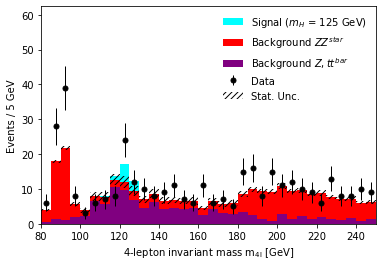

In [10]:
# Plot the histograms
hist.Hist.plot1d(output['Data'], histtype='errorbar', color='black')
hist.Hist.plot1d(output['MC'], stack=True, histtype='fill', color=['purple', 'red', 'cyan'])

# Basic bin parameters
xmin = 80
xmax = 250
step_size = 5

bin_centers = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Calculate background statistical uncertainty
# Remove the "[:,:2]" expressions to use all MC datasets with background and signal combined
mc_tot_var = np.sum(output['MC'].variances()[:,:2], axis=1)
mc_err = np.sqrt(mc_tot_var)
mc_tot_height = np.sum(output['MC'].values()[:,:2], axis=1)

# Plot background statistical uncertainty
plt.bar(bin_centers, # x
        2*mc_err, # heights
        alpha=0.5, # half transparency
        bottom=mc_tot_height-mc_err, color='none', 
        hatch="////", width=step_size, label='Stat. Unc.')

# Tune plot appearance
main_axes = plt.gca()
main_axes.set_xlim(left=xmin, right=xmax)
main_axes.set_ylim(bottom=0, top=np.amax(output['Data'].values())*1.6)
main_axes.set_ylabel('Events / '+str(step_size)+' GeV')
main_axes.legend(frameon=False)